In [1]:
import tensorflow as tf


#direct using models to predict the class
#rememeber the class has to be one of the labels

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
model = VGG16(weights='imagenet')
img_path = 'tree_frog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n01644373', 'tree_frog', 0.97914004), ('n01644900', 'tailed_frog', 0.010300734), ('n02259212', 'leafhopper', 0.0053335633)]


#feature extraction


In [1]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file(fname='catsanddogs.zip', origin=URL, cache_dir='/content',extract=True)


68606236/68606236 [==============================] - 4s 0us/step


In [3]:
path_to_zip

'/content/datasets/catsanddogs.zip'

In [4]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [5]:
train_dir = os.path.join(PATH, 'train')

In [6]:
validation_dir = os.path.join(PATH, 'validation')

In [7]:
os.path.dirname(path_to_zip)

'/content/datasets'

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [9]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [10]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

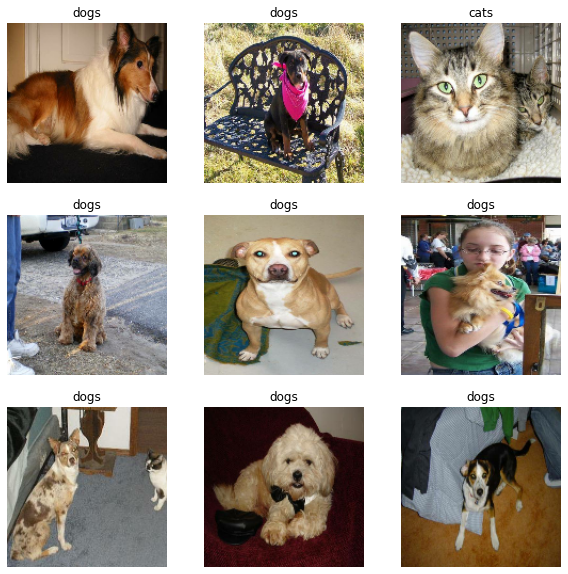

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [12]:
val_batches=tf.data.experimental.cardinality(validation_dataset)
print(val_batches)
#we have 32 baches


tf.Tensor(32, shape=(), dtype=int64)


In [13]:
#lets move 20 percent of them to test set
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

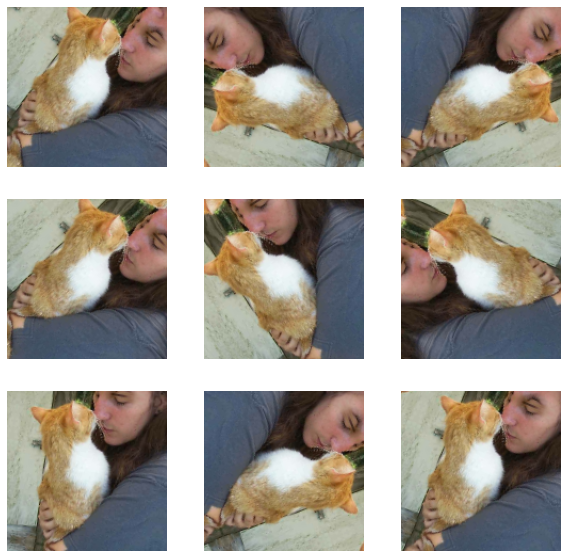

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[1]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [19]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Create the base model from the pre-trained model vgg16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 3s 0us/step


In [20]:
IMG_SHAPE

(150, 150, 3)

In [21]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [22]:
#This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 512)


In [23]:
#freeze the base model layers so that they’re not updated during the training process
base_model.trainable = False

In [24]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)  
#use training=False as model might contains a BatchNormalization layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
len(model.trainable_variables)  #1 for weights and 1 for bias

2

In [28]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset)

Epoch 1/30
63/63 [==============================] - 12s 168ms/step - loss: 2.2820 - accuracy: 0.6725 - val_loss: 1.2754 - val_accuracy: 0.7834
Epoch 2/30
63/63 [==============================] - 10s 148ms/step - loss: 1.8863 - accuracy: 0.7115 - val_loss: 1.0819 - val_accuracy: 0.8131
Epoch 3/30
63/63 [==============================] - 9s 139ms/step - loss: 1.7721 - accuracy: 0.7280 - val_loss: 0.9122 - val_accuracy: 0.8267
Epoch 4/30
63/63 [==============================] - 9s 141ms/step - loss: 1.3903 - accuracy: 0.7670 - val_loss: 0.7707 - val_accuracy: 0.8502
Epoch 5/30
63/63 [==============================] - 9s 141ms/step - loss: 1.4234 - accuracy: 0.7630 - val_loss: 0.6743 - val_accuracy: 0.8663
Epoch 6/30
63/63 [==============================] - 9s 141ms/step - loss: 1.3824 - accuracy: 0.7770 - val_loss: 0.6422 - val_accuracy: 0.8713
Epoch 7/30
63/63 [==============================] - 9s 143ms/step - loss: 1.1381 - accuracy: 0.8035 - val_loss: 0.5764 - val_accuracy: 0.8824
Epoc

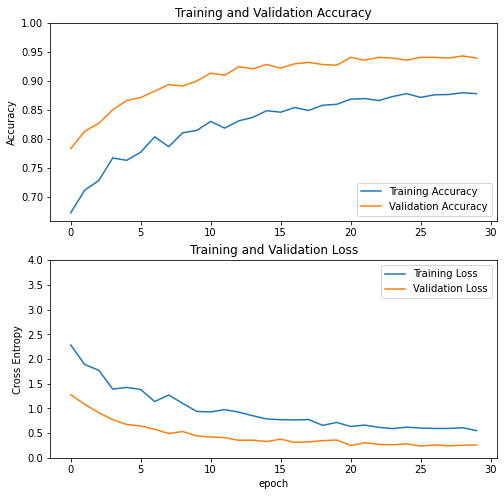

In [29]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 84ms/step - loss: 0.5431 - accuracy: 0.9219
Test accuracy : 0.921875


In [31]:
base_model.trainable = True


In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [33]:
# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [45]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [46]:

total_epochs =  5

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         validation_data=validation_dataset)

Epoch 1/5
63/63 [==============================] - 11s 145ms/step - loss: 0.5759 - accuracy: 0.8835 - val_loss: 0.2327 - val_accuracy: 0.9493
Epoch 2/5
63/63 [==============================] - 9s 145ms/step - loss: 0.4645 - accuracy: 0.8970 - val_loss: 0.2321 - val_accuracy: 0.9505
Epoch 3/5
63/63 [==============================] - 9s 146ms/step - loss: 0.4513 - accuracy: 0.9065 - val_loss: 0.2003 - val_accuracy: 0.9542
Epoch 4/5
63/63 [==============================] - 10s 148ms/step - loss: 0.3630 - accuracy: 0.9085 - val_loss: 0.2076 - val_accuracy: 0.9517
Epoch 5/5
63/63 [==============================] - 10s 148ms/step - loss: 0.3589 - accuracy: 0.9245 - val_loss: 0.2338 - val_accuracy: 0.9505


In [48]:
history_fine = model.fit(train_dataset,
                         epochs=15,
                         validation_data=validation_dataset)

Epoch 1/15
63/63 [==============================] - 10s 146ms/step - loss: 0.3215 - accuracy: 0.9270 - val_loss: 0.2010 - val_accuracy: 0.9579
Epoch 2/15
63/63 [==============================] - 10s 148ms/step - loss: 0.3656 - accuracy: 0.9235 - val_loss: 0.2102 - val_accuracy: 0.9554
Epoch 3/15
63/63 [==============================] - 10s 148ms/step - loss: 0.3091 - accuracy: 0.9275 - val_loss: 0.1795 - val_accuracy: 0.9616
Epoch 4/15
63/63 [==============================] - 10s 149ms/step - loss: 0.2901 - accuracy: 0.9310 - val_loss: 0.1835 - val_accuracy: 0.9592
Epoch 5/15
63/63 [==============================] - 10s 149ms/step - loss: 0.2837 - accuracy: 0.9260 - val_loss: 0.1904 - val_accuracy: 0.9641
Epoch 6/15
63/63 [==============================] - 10s 148ms/step - loss: 0.2518 - accuracy: 0.9315 - val_loss: 0.1696 - val_accuracy: 0.9604
Epoch 7/15
63/63 [==============================] - 9s 146ms/step - loss: 0.2414 - accuracy: 0.9415 - val_loss: 0.1982 - val_accuracy: 0.9629


In [49]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 84ms/step - loss: 0.2236 - accuracy: 0.9635
Test accuracy : 0.9635416865348816


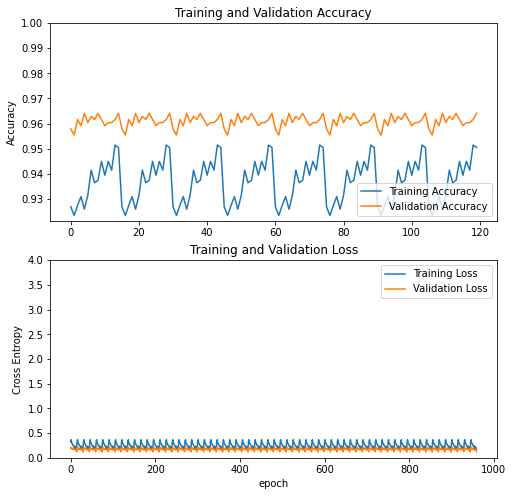

In [60]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
 


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


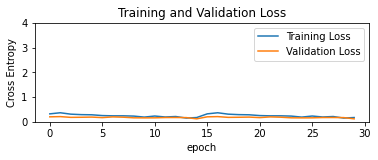